<a href="https://colab.research.google.com/github/widayatwidi/sentiment-IMDB-Movie/blob/master/sentiment-analysis-movie-app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls "/content/drive/My Drive/ThesisCode/SA-Orielly"

a-owntrainmovie.ipynb  positive		    thesis
combine		       positiveReviews	    train-ownembedding.ipynb
glove.6B.50d.txt       prepro		    word2vec.ipynb
idsMatrix.npy	       reviews_data.txt.gz  wordsList.npy
negative	       sentimentLSTM.ipynb  wordVectors.npy
negativeReviews        tensorboard


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11039873054015527811, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11086197301739303369
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8087318966703861944
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7304675328
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9923837402416250263
 physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"]

In [5]:
!cat /proc/meminfo

MemTotal:       13335188 kB
MemFree:         8941428 kB
MemAvailable:   11776396 kB
Buffers:           77552 kB
Cached:          2893756 kB
SwapCached:            0 kB
Active:          1327732 kB
Inactive:        2643480 kB
Active(anon):     952944 kB
Inactive(anon):     8524 kB
Active(file):     374788 kB
Inactive(file):  2634956 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              4332 kB
Writeback:             0 kB
AnonPages:        999524 kB
Mapped:           722260 kB
Shmem:              9108 kB
Slab:             175680 kB
SReclaimable:     132140 kB
SUnreclaim:        43540 kB
KernelStack:        4680 kB
PageTables:        10068 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6667592 kB
Committed_AS:    3847512 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
ShmemHugePages:  

# **Embedding Vector dg Training sendiri pake Word2Vec**

**Import semua library**

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import resample
from keras.layers import SimpleRNN
from keras.models import load_model

import pickle
import json
import re
import pandas as pd
import numpy as np
import tensorflow as tf

import gensim
import seaborn as sns
import matplotlib.pyplot as plt

tf.test.gpu_device_name()

import os

import sys
import glob

!pip install gensim
from gensim.models import Word2Vec

## **Preprocessing untuk menyiapkan dataset** -- x train x test dan x val

**Preprocessing bawaan** --  mengubah review ke dalam bentuk embedded

In [8]:
#stopwords = open('data/stopwords.txt', 'r').read().splitlines()

# import json
# import glob

def clean_chars(sent):
    url_remove = re.sub(r'http\S+', ' ', sent.lower())
    char_remove = re.sub(r'[^a-zA-Z0-9#@]', ' ', url_remove)
    char_len = [i for i in char_remove.split() if len(i) > 2]
    #temp = [i for i in char_len if not i.startswith('#') and not i.startswith('@') and i not in stopwords]
    temp = [i for i in char_len if not i.startswith('#') and not i.startswith('@')]
    return ' '.join(temp)

def sync_data(pos, neg):
    dict = {'pos': len(pos), 'neg': len(neg)}
    lowest = min(dict.items(), key=lambda x: x[1])

    pos = resample(pos,replace=False, n_samples=lowest[1], random_state=123)
#     neu = resample(neu,replace=False, n_samples=lowest[1], random_state=123)
    neg = resample(neg,replace=False, n_samples=lowest[1], random_state=123)

    return pos, neg

pos = []
neg = []
# neu = []

pos_label = []
neg_label = []
# neu_label = []

#proses di bawah ini adalah mengambil konten atau text2 yang terdapat pada dataset, jadi hanya mengambil review text nya saja

with open('/content/drive/My Drive/ThesisCode/SA-Orielly/combine/data_preddict.json') as f:
    data = json.load(f)
   
for d in data:
  if d['sentiment'] == 'positive':
      content = clean_chars(d['texts'])
      pos_label.append(d['sentiment'])
      pos.append(content)

  elif d['sentiment'] == 'negative':
      content = clean_chars(d['texts'])
      neg_label.append(d['sentiment'])
      neg.append(content)

#   elif d['sentiment'] == 'neutral':
#       content = clean_chars(d['texts'])
#       neu_label.append(d['sentiment'])
#       neu.append(content)
      
pos, neg = sync_data(pos, neg)

print("Pos: %s, Neg: %s" % (len(pos), len(neg)))

statuses = pos + neg

print("Total data: %s" % len(statuses))

pos_label, neg_label = sync_data(pos_label, neg_label)

labels = pos_label + neg_label

Pos: 12500, Neg: 12500
Total data: 25000


In [9]:
statuses[0]

'this documentary explores story covered pilger latest book freedom next time which was published 2006 reveals the shocking expulsion the natives diego garcia one the chagos islands the indian ocean the islanders are technically british citizens diego garcia british colony much like mauritius the nearby island where the natives were exiled used but the british government has ignored their pleas return their homeland the island now military base for the united states army who have used basis for the bombing iraq and afghanistan usual pilger coverage shocking especially documents the treatment and the current impoverished living conditions the surviving islanders his interviews all round are excellent and his cornering parliament representative where uses the government own information pin him down ranks one his best pilger also uses dramatic reconstruction dissect series recently released documents that fully illuminate the british conspiracy evict the natives the weaving this footage w

In [0]:
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(statuses)

X = tokenizer.texts_to_sequences(statuses)
X = pad_sequences(X)

Y = pd.get_dummies(labels).values

In [11]:
len(X[0])

1586

In [12]:
print(X[0])

[   0    0    0 ...   14   91 1111]


In [13]:
Y[0]

array([0, 1], dtype=uint8)

In [14]:
X.shape

(25000, 1586)

**Pembagian dataset**

In [0]:
# penggunaan testing size sebesar 0.1 dari total dataset

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [16]:
X_train.shape

(20250, 1586)

In [17]:
X_test.shape

(2500, 1586)

In [18]:
X_val.shape

(2250, 1586)

In [0]:
from keras.preprocessing import sequence

max_words = 300
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
X_val = sequence.pad_sequences(X_val, maxlen=max_words)

In [20]:
X_train

array([[   0,    0,    0, ..., 1246, 3963, 4164],
       [   0,    0,    0, ...,  774,  251,  429],
       [   0,    0,    0, ..., 1153,  313,  741],
       ...,
       [   0,    0,    0, ...,  485,  463,  477],
       [   0,    0,    0, ..., 1193,   11,   94],
       [   0,    0,    0, ...,    3,    8,  170]], dtype=int32)

## **Mari mulai dengan preprocessing** -- menyiapkan data untuk ditraining membentuk vektor

**Preprocessing data** 

In [0]:
# stopwords = open('data/stopwords.txt', 'r').read().splitlines()

def clean_chars(sent):
    url_remove = re.sub(r'http\S+', ' ', sent.lower())
    char_remove = re.sub(r'[^a-zA-Z0-9#@]', ' ', url_remove)
    char_len = [i for i in char_remove.split() if len(i) > 2]
    temp = [i for i in char_len if not i.startswith('#') and not i.startswith('@')]
#     temp = [i for i in char_len if not i.startswith('#') and not i.startswith('@') and i not in stopwords]
    return ' '.join(temp)

pos = []
neg = []
# neu = []

with open('/content/drive/My Drive/ThesisCode/SA-Orielly/combine/data_preddict.json') as f:
    data = json.load(f)
    
for d in data:
  if d['sentiment'] == 'positive':
      content = clean_chars(d['texts'])
      pos.append(content.split(" "))
  elif d['sentiment'] == 'negative':
      content = clean_chars(d['texts'])
      neg.append(content.split(" "))

#   elif d['sentiment'] == 'neutral':
#       content = clean_chars(d['texts'])
#       neu.append(content.split(" "))
      
documents = pos + neg

In [22]:
print('Maximum review length: {}'.format(
len(max((pos), key=len))))

Maximum review length: 2090


**Cek data setelah preprocessing**

In [23]:
# semua review dipisah dan menjadi susunan kata-kata (words)

documents

[['spanish',
  'films',
  'are',
  'into',
  'not',
  'golden',
  'definitely',
  'silver',
  'age',
  'dras',
  'another',
  'example',
  'movie',
  'that',
  'takes',
  'people',
  'and',
  'their',
  'conflicts',
  'seriously',
  'although',
  'the',
  'feelings',
  'are',
  'strong',
  'nearly',
  'life',
  'death',
  'level',
  'they',
  'still',
  'aren',
  'really',
  'melodramatic',
  'this',
  'could',
  'happen',
  'there',
  'are',
  'different',
  'stories',
  'here',
  'which',
  'become',
  'connected',
  'one',
  'about',
  'the',
  'retarded',
  'girl',
  'who',
  'doesn',
  'dare',
  'pass',
  'the',
  'street',
  'the',
  'next',
  'block',
  'one',
  'about',
  'the',
  'middle',
  'aged',
  'woman',
  'who',
  'finds',
  'the',
  'lover',
  'her',
  'life',
  'foot',
  'fetischist',
  'another',
  'about',
  'the',
  'girl',
  'with',
  'drug',
  'problems',
  'who',
  'lover',
  'leaves',
  'her',
  'still',
  'another',
  'one',
  'about',
  'the',
  'madame',
  '

In [24]:
len(documents)

25000

In [25]:
documents[1]
print(documents[1])

['several', 'story', 'lines', 'are', 'interwoven', 'here', 'around', 'different', 'women', 'characters', 'the', 'shoes', 'they', 'wear', 'serve', 'indication', 'their', 'troubled', 'lives', 'all', 'are', 'transformed', 'the', 'end', 'the', 'movie', 'adela', 'antonia', 'san', 'juan', 'leads', 'brothel', 'her', 'daughter', 'anita', 'monica', 'cervera', 'retarded', 'and', 'has', 'restricted', 'life', 'leire', 'najwa', 'nimri', 'shoe', 'designer', 'with', 'problems', 'and', 'loses', 'her', 'boyfriend', 'maricarmen', 'vicky', 'has', 'lost', 'her', 'husband', 'and', 'now', 'raises', 'the', 'children', 'from', 'his', 'deceased', 'former', 'wife', 'isabel', 'ngela', 'molina', 'bored', 'rich', 'lady', 'other', 'characters', 'are', 'used', 'connect', 'the', 'five', 'main', 'women', 'characters', 'storytelling', 'not', 'everything', 'given', 'away', 'the', 'beginning', 'some', 'connections', 'are', 'established', 'surprisingly', 'late', 'the', 'movie', 'and', 'that', 'adds', 'the', 'experience', 

In [26]:
len(documents[1])

333

**Train kumpulan word dengan menggunakan model word2vec**

In [27]:
model = Word2Vec(documents, min_count=1, size=50, sg=1)
# model.save('w2v-cbow.bin')
model.save('/content/drive/My Drive/ThesisCode/SA-Orielly/thesis/word2vec-train/w2v-skip-50-test.bin')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [28]:
model

In [29]:
model["good"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.4889001 ,  0.09624452,  0.5479844 , -0.05354311, -0.22695023,
        0.05759808,  0.3884069 ,  0.14483592,  0.7088314 ,  0.27174732,
       -0.15901224,  0.3237862 , -0.34965703,  0.46606627,  0.21373315,
        0.02693472, -0.13878599, -0.48057964,  0.0906712 ,  0.28174952,
        0.06407314,  0.02783599, -0.14404075,  0.39614403,  0.25987506,
       -0.5729898 ,  0.7129175 , -0.5070428 , -0.47168338,  0.21854125,
        0.19825861,  0.25305286, -0.15064123,  0.46361127,  0.60998   ,
        0.15792163,  0.35399252,  0.28982922, -0.15692465,  0.05727077,
        0.32986832,  0.8851018 , -0.18460438,  1.1990278 ,  0.27821743,
       -0.7077867 , -0.07625715, -0.03683526, -0.22072707,  0.1520515 ],
      dtype=float32)

In [30]:
model["good"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.4889001 ,  0.09624452,  0.5479844 , -0.05354311, -0.22695023,
        0.05759808,  0.3884069 ,  0.14483592,  0.7088314 ,  0.27174732,
       -0.15901224,  0.3237862 , -0.34965703,  0.46606627,  0.21373315,
        0.02693472, -0.13878599, -0.48057964,  0.0906712 ,  0.28174952,
        0.06407314,  0.02783599, -0.14404075,  0.39614403,  0.25987506,
       -0.5729898 ,  0.7129175 , -0.5070428 , -0.47168338,  0.21854125,
        0.19825861,  0.25305286, -0.15064123,  0.46361127,  0.60998   ,
        0.15792163,  0.35399252,  0.28982922, -0.15692465,  0.05727077,
        0.32986832,  0.8851018 , -0.18460438,  1.1990278 ,  0.27821743,
       -0.7077867 , -0.07625715, -0.03683526, -0.22072707,  0.1520515 ],
      dtype=float32)

In [31]:
w1 = "bad"
model.wv.most_similar (positive=w1)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('awful', 0.8967161178588867),
 ('terrible', 0.8893374800682068),
 ('horrible', 0.8846278190612793),
 ('good', 0.874567985534668),
 ('lousy', 0.8619984984397888),
 ('sucked', 0.8564064502716064),
 ('cheesy', 0.8476770520210266),
 ('sucks', 0.8274251818656921),
 ('cheezy', 0.8273828625679016),
 ('soooo', 0.8257134556770325)]

In [32]:
w1 = ["orange"]
model.wv.most_similar(positive=w1, topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('clockwork', 0.8524467945098877),
 ('neon', 0.8225608468055725),
 ('shiny', 0.8052366971969604),
 ('lagoon', 0.8026415705680847),
 ('yellow', 0.7988272309303284)]

**Tampilkan similarity ke dalam bentuk dimensi 2 - PCA**

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


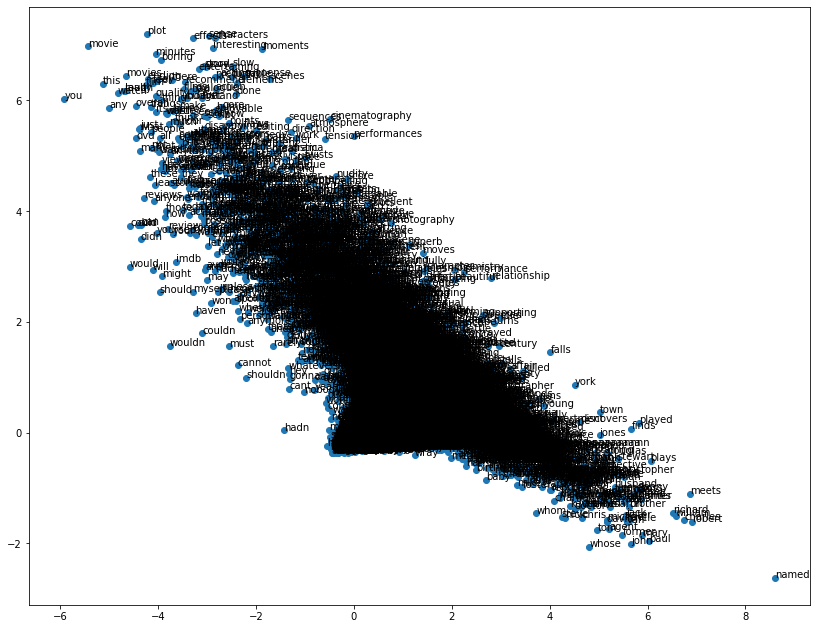

In [33]:
from sklearn.decomposition import PCA
from matplotlib import pyplot

# model = Word2Vec.load('w2v-cbow.bin')
model = Word2Vec.load('/content/drive/My Drive/ThesisCode/SA-Orielly/thesis/word2vec-train/w2v-cbow-300.bin')
# print(model['jokowi'])

X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# create a scatter plot of the projection
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 11
pyplot.rcParams["figure.figsize"] = fig_size

pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [0]:
model.wv.doesnt_match(["bed","pillow","duvet","shower"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'duvet'

In [0]:
model.wv.doesnt_match(["cat","dog","france"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'france'

# **Buat model LSTM baru dengan menggunakan vektor yang sudah dibentuk**

**Buat model LSTM
**

In [0]:
# CODE INI BELUM DIRUN, hanya untuk melihat
# ukuran dimensi untuk vektor yang dicoba adalah 32

from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import *

embedding_size=60
units = 50

model=Sequential()
model.add(Embedding(max_features, embedding_size, input_length=max_words))
embeddings = model.layers[0].get_weights()[0]
#words_embeddings = {w:embeddings[idx] for w, idx in word_to_index.items()}
print(embeddings[15])



max_features = 3000
embed_dim = 128
lstm_units = 196

def create_embedding_matrix(model):
    embedding_matrix = np.zeros((len(model.wv.vocab), embed_dim))
    for i in range(len(model.wv.vocab)):
        embedding_vector = model.wv[model.wv.index2word[i]]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# model = gensim.models.Word2Vec.load("w2v/w2v-cbow.bin")
model = gensim.models.Word2Vec.load("w2v/w2v-skipgram.bin")
embedding_matrix = create_embedding_matrix(model)

model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights=[embedding_matrix]))
# model.add(LSTM(lstm_units, dropout=0.2))
model.add(SimpleRNN(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())


batch_size = 1000
history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

score, accuracy = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=1)
print("score: ", score)
print("accuracy: ", accuracy)



In [0]:
embed_dim = 50

def create_embedding_matrix(model):
    embedding_matrix = np.zeros((len(model.wv.vocab), embed_dim))
    for i in range(len(model.wv.vocab)):
        embedding_vector = model.wv[model.wv.index2word[i]]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# model = gensim.models.Word2Vec.load("w2v/w2v-cbow.bin")
model = gensim.models.Word2Vec.load("/content/drive/My Drive/ThesisCode/SA-Orielly/thesis/word2vec-train/w2v-skip-50-test.bin")
embedding_matrix = create_embedding_matrix(model)


In [0]:
embedding_matrix.shape

(73736, 50)

In [0]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import *

model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights=[embedding_matrix]))
embeddings = model.layers[0].get_weights()[0]
#words_embeddings = {w:embeddings[idx] for w, idx in word_to_index.items()}
print(embeddings[3])

# model.add(LSTM(lstm_units, dropout=0.2))
# model.add(SimpleRNN(units, dropout=0.2))
# model.add(Dense(3,activation='softmax'))
# model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
# print(model.summary())


[-0.1429889  -0.12757184  0.40217736 -0.43021747  0.31674114 -0.5247571
  0.14696741 -0.2476661   0.23987561 -0.517169    0.4056121  -0.26597187
  0.31582096 -0.16689916 -0.53718656  0.23624761  0.18593688  0.29645965
 -0.26625296  0.24098544 -0.1072726  -0.10794163 -0.01367717 -0.63898563
 -0.11960187 -0.42195353  0.1594725  -0.31637162 -0.49681696 -0.16435803
  0.2924631  -0.21727048 -0.1996887   0.17922352  0.38893262  0.44053575
 -0.07487147  0.24279433 -0.00419947 -0.22625636 -0.5602067  -0.16933702
 -0.47527587 -0.06708952 -0.4772177  -0.353182   -0.1312793  -0.6398076
  0.15601048  0.01616441]


In [0]:
embeddings[3]

array([-0.17379442,  0.08751847,  0.08317005, -0.23997518,  0.203907  ,
       -0.48525152,  0.12374973, -0.10103943,  0.13247085, -0.6264201 ,
        0.17892274, -0.26690555,  0.28792998, -0.14579757, -0.43401214,
        0.09814445,  0.15585995,  0.36265728, -0.21299466,  0.36463952,
       -0.3664245 , -0.10524676, -0.00130731, -0.3447284 , -0.46465462,
       -0.3000648 , -0.04154132, -0.3415594 , -0.33573353, -0.1804854 ,
        0.24451272,  0.06741084,  0.14941263,  0.2871031 ,  0.47172526,
        0.5878627 , -0.07666147,  0.15823758, -0.12065522, -0.20119902,
       -0.6913491 , -0.42616284, -0.35867915,  0.02210391, -0.5945304 ,
       -0.27688405, -0.18995129, -0.6468448 ,  0.09825936, -0.02138442],
      dtype=float32)

In [0]:
embeddings.shape

(73736, 50)

In [0]:
embedding_matrix.shape[1]

50

In [0]:
units = 50

model=Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights=[embedding_matrix]))
# model.add(LSTM(units, dropout=0.2, return_sequences = True))
model.add(LSTM(units, dropout=0.5))
# model.add(LSTM(units))
# model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 50)          3686800   
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total params: 3,707,102
Trainable params: 3,707,102
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())


batch_size = 64
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

score, accuracy = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=1)
print("score: ", score)
print("accuracy: ", accuracy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 50)          3686800   
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total params: 3,707,102
Trainable params: 3,707,102
Non-trainable params: 0
_________________________________________________________________
None
Train on 20250 samples, validate on 2500 samples
Epoch 1/10
20250/20250 [==============================] - 180s 9ms/step - loss: 0.6812 - acc: 0.5546 - val_loss: 0.6305 - val_acc: 0.6440
Epoch 2/10
20250/20250 [==============================] - 179s 9ms/step - loss: 0.5736 - acc: 0.7004 - val_loss: 0.4652 - val_acc: 0.7850
Epoch 3/10
20250/20250 [==============================] - 179s 9ms

**Grafik akurasi**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


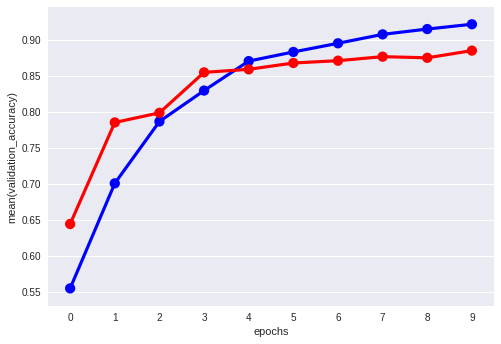

In [0]:
df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False, color='blue')
g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='red')

**Save model yang sudah ditraining**

In [0]:
model.save('/content/drive/My Drive/ThesisCode/SA-Orielly/thesis/model-w2v/model-lstm-50-testingb.h5')
# model.save('model/model-lstm.h5')
print("Model has created!")

Model has created!


**Testing model**

In [0]:
#test untuk review positive

#Pos
input_text = "My boyfriend and I went to watch The Guardian.At first I didn't want to watch it, but I loved the movie- It was definitely the best movie I have seen in sometime.They portrayed the USCG very well, it really showed me what they do and I think they should really be appreciated more.Not only did it teach but it was a really good movie. The movie shows what the really do and how hard the job is.I think being a USCG would be challenging and very scary. It was a great movie all around. I would suggest this movie for anyone to see.The ending broke my heart but I know why he did it. The storyline was great I give it 2 thumbs up. I cried it was very emotional, I would give it a 20 if I could!"

#Neg
# input_text = "Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in."

# proses preprocessing data

text = [clean_chars(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=max_words)

# load model yang sudah ditrain

model = load_model('/content/drive/My Drive/ThesisCode/SA-Orielly/thesis/model-w2v/model-lstm-50-testingb.h5')
# model = load_model('model/model-rnn.h5')
prediction = model.predict(guess, verbose=1)
polarity = np.argmax(prediction[0])

sentiment = ['negative', 'positive']

print("Text: ",input_text)
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 428ms/step
Text:  My boyfriend and I went to watch The Guardian.At first I didn't want to watch it, but I loved the movie- It was definitely the best movie I have seen in sometime.They portrayed the USCG very well, it really showed me what they do and I think they should really be appreciated more.Not only did it teach but it was a really good movie. The movie shows what the really do and how hard the job is.I think being a USCG would be challenging and very scary. It was a great movie all around. I would suggest this movie for anyone to see.The ending broke my heart but I know why he did it. The storyline was great I give it 2 thumbs up. I cried it was very emotional, I would give it a 20 if I could!
Sentiment:  positive


In [12]:
!git init

Reinitialized existing Git repository in /content/.git/


In [0]:
!git config --global user.email "widayatwidi26@gmail.com"
!git config --global user.name "Widi Widayat"

In [0]:
!git add .

In [0]:
!git config --global user.email "widayatwidi26@gmail.com"
!git config --global user.name "Widi Widayat"



In [15]:
!git commit -m "firt initialize - commit from google colab"

On branch master
nothing to commit, working tree clean


In [16]:
!git remote add origin https://github.com/widayatwidi/sentiment-IMDB-Movie.git

fatal: remote origin already exists.


In [0]:
!git remote rm origin

In [21]:
!git push -u origin master

fatal: 'origin' does not appear to be a git repository
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
